<img src="../PythonBootcamp/support_files/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Introduction to Point Neuronal Network Modeling</h1> 
<h3 align="center">August, 2017</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
## Changes 
#### Changes have been made which are summarized below. There are also comments throughout the notebook when needed. 


config.json
* In network parameters changed:
 * edges → connections
 * nodes → cells
 * node_types → cell_models      
* func_labels are no longer applicable.
* In components only need two directories; cell_models/ and synaptic_models
* In run needed to change tstop to duration
  * Added “block”: false
  * dL, spike_threshold, nsteps_block, save_cell_vars and calc_ecp are not applicable for pointnet.
* recXelectrode, conditions, groups are no longer applicable

node_types
* Need a “model_type” column to specify NEST model to use. spike_generator should be used for input nodes and iaf_psc_alpha is the most standard IAF type NEST model
* Make sure there is a params_file column that points to the value in “components/models_dir”

models_dir
* Swapped out the json files from CellTypes based to one with NEST values

edge_types:
* Need a synapse_model column (static_synapse)
* Readded the weight function
  NOTE: We can remove weight-function like we did for bionet. However without the weight function we would have no way of * determining the number of synapses.

weight_functions
* function needs to include nsyn
	


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
## Drive path

First things first - let's make sure your drive path is set up appropriately. All these files are already saved in the AWS directory drive path below.

In [ ]:
drive_path = '/data/dynamic-brain-workshop/modeling/pointnet_notebook'

In [1]:
import os
import sys
import pandas as pd
import numpy as np# Print the first 5 external nodes
import modelingsdk.simulator.utils.config as config
from modelingsdk.simulator.pointnet.graph import Graph
from modelingsdk.simulator.pointnet import nest_construction

import json
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


import set_weights as wf

# Some functions in modelingSDK for faster reading of the config files
configure = config.from_json('config.json')

# Reads and loads the config file
graph = Graph(configure)

# This will not be required for future versions (will be optional). Allows users to have different
# weight functions. Here we will just use the weight as is. See set_weights.py if interested of another example.
graph.add_weight_function(wf.wmax)

# Create network for NEST. Can just give the configure and graph - also possible for biophysical networks.
net = nest_construction.Network(configure, graph)

# Run the network for a specific duration - note NEST uses "duration" while we used "tstop" for NEURON.
net.run(configure['run']['duration'])


building
-1 -1 -1


In [2]:
directory_name = 'network/recurrent_network/'

In [3]:
# Nodes files
nodes_file = directory_name + 'nodes.csv'              # Contains information about every node
node_models_file = directory_name + 'node_types.csv'   # Contains information about models

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Below we show the nodes again. Note that rotation_angle_yaxis has no real meaning for point neurons. Notetheless we can use the same nodes file and the required columns will be used and anything extra ignored by the NEST simulator!

In [4]:
# Show the nodes file
nodes_DF = pd.DataFrame.from_csv(nodes_file, sep = ' ')
nodes_DF 

,node_type_id,x_soma,y_soma,z_soma,rotation_angle_yaxis,pop_name,ei
node_id,,,,,,,
0,10002,0.599701,0.766946,0.633423,2.885581,PV1,i
1,10002,0.645736,0.412866,0.898236,2.165759,PV1,i
2,10001,0.167588,0.305917,0.313421,5.187670,Scnn1a,e
3,10001,0.716176,0.680169,0.707616,1.643158,Scnn1a,e
4,90002,0.130936,0.488126,0.933411,2.258221,LIF_inh,i
5,90002,0.812379,0.646783,0.912145,1.585785,LIF_inh,i
6,90001,0.918889,0.875095,0.746574,1.066052,LIF_exc,e
7,90001,0.087999,0.602706,0.924731,6.278741,LIF_exc,e


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
The node_types file needed some changed to the correct model_type (explore the files if interested in the components subdirectory).

In [5]:
# Show the node_types file. Note the common column is node_type_id
node_types_DF = pd.DataFrame.from_csv(node_models_file, sep = ' ')
node_types_DF

,model_type,params_file,level_of_detail,morphology_file,rotation_angle_zaxis,set_params_function
node_type_id,,,,,,
10002,iaf_psc_alpha,472912177_fit.json,biophysical,Pvalb-IRES-Cre_Ai14_IVSCC_-176847.04.02.01_470...,-2.539552,Biophys1
10001,iaf_psc_alpha,472363762_fit.json,biophysical,Scnn1a-Tg3-Cre_Ai14_IVSCC_-177300.01.02.01_473...,-3.646878,Biophys1
90002,iaf_psc_alpha,IntFire1_inh_1.json,intfire,NaN,NaN,IntFire1
90001,iaf_psc_alpha,IntFire1_exc_1.json,intfire,NaN,NaN,IntFire1


In [6]:
# Edges files
edge_types_file = directory_name + 'edge_types.csv'   # Contains info. about every edge type
edges_file = directory_name + 'edges.h5'             # Contains info. about every edge created

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
For edges, some lines will be ignored as don't have biophysical level of detail here (as well as some columns). Moreoever, the weights have been change and note that when the source is inhibitory, the weight is negative. Two extra columns of synapse_model and weight function were added. Synapse_model is required by NEST and we are using the most basic synapse type here. Weight_function will be optional (to be changed in modelingSDK) but is required now and just tells the simulator to use the weight_max value as a constant.

In [7]:
edge_types_DF = pd.DataFrame.from_csv(edge_types_file, sep = ' ')
edge_types_DF

,target_query,source_query,weight_max,distance_range,target_sections,delay,params_file,set_params_function,synapse_model,weight_function
edge_type_id,,,,,,,,,,
0,level_of_detail=='biophysical'&ei=='i',ei=='i',-10.0,"[0.0, 1e+20]","['somatic', 'basal']",2.0,GABA_InhToInh.json,exp2syn,static_synapse,wmax
1,level_of_detail=='intfire'&ei=='i',ei=='i',-50.0,NaN,NaN,2.0,instanteneousInh.json,NaN,static_synapse,wmax
2,level_of_detail=='biophysical'&ei=='e',ei=='i',-50.0,"[0.0, 50.0]","['somatic', 'basal', 'apical']",2.0,GABA_InhToExc.json,exp2syn,static_synapse,wmax
3,level_of_detail=='intfire'&ei=='e',ei=='i',-10.0,NaN,NaN,2.0,instanteneousInh.json,NaN,static_synapse,wmax
4,pop_name=='PV1',ei=='e',100.0,"[0.0, 1e+20]","['somatic', 'basal']",2.0,AMPA_ExcToInh.json,exp2syn,static_synapse,wmax
5,pop_name=='LIF_inh',ei=='e',100.0,NaN,NaN,2.0,instanteneousExc.json,NaN,static_synapse,wmax
6,pop_name=='Scnn1a',ei=='e',100.0,"[30.0, 150.0]","['basal', 'apical']",2.0,AMPA_ExcToExc.json,exp2syn,static_synapse,wmax
7,pop_name=='LIF_exc',ei=='e',100.0,NaN,NaN,2.0,instanteneousExc.json,NaN,static_synapse,wmax


In [8]:
# Output file names
directory_name = 'network/source_input/'
input_nodes_file        = directory_name + 'input_nodes.csv'
input_models_file       = directory_name + 'input_node_types.csv'
input_edge_types_file   = directory_name + 'input_edge_types.csv'
input_edges_file        = directory_name + 'input_edges.h5'

In [9]:
# Print the first 5 external nodes
input_nodes_DF = pd.DataFrame.from_csv(input_nodes_file, sep = ' ')
input_nodes_DF[1:5]

,node_type_id,ei,pop_name
node_id,,,
1,1001,e,input_filter
2,1001,e,input_filter
3,1001,e,input_filter
4,1001,e,input_filter


In [10]:
# Print the external node types
input_node_types_DF = pd.DataFrame.from_csv(input_models_file, sep = ' ')
input_node_types_DF

,model_type,params_file,level_of_detail
node_type_id,,,
1001,spike_generator,filter_point.json,filter


In [11]:
input_edge_types_DF = pd.DataFrame.from_csv(input_edge_types_file, sep = ' ')
input_edge_types_DF

,target_query,source_query,weight_max,distance_range,target_sections,delay,params_file,set_params_function,synapse_model,weight_function
edge_type_id,,,,,,,,,,
7,pop_name=='Scnn1a',*,25.0,"[0.0, 150.0]","['basal', 'apical']",2.0,AMPA_ExcToExc.json,exp2syn,static_synapse,wmax
8,pop_name=='LIF_exc',*,50.0,NaN,NaN,2.0,instanteneousExc.json,NaN,static_synapse,wmax


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Visualize the output spike trains

In [ ]:
with open('config.json') as config:
    config_file = json.load(config)
    
# Load the spikes
spks = np.loadtxt(config_file['manifest']['$OUTPUT_DIR'][10:] + config_file['output']['spikes_ascii'][11:])

# Print the first 10 spikes
# spks[:, 0] is the spike-time
# spks[:, 1] is the neuron id that fired at that time
print spks[1:10, :]

building
-1 -1 -1
[[    9.    608. ]
 [    6.    613.5]
 [    7.    613.5]
 [    8.    614.2]
 [    6.    618.8]
 [    7.    620. ]
 [    8.   2366.8]
 [    9.   2366.8]
 [    6.   2372.3]]


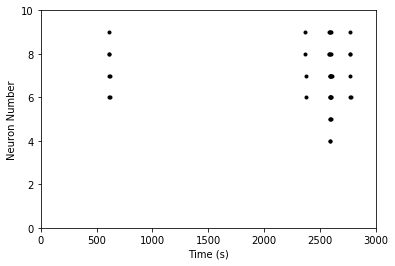

In [14]:
# Basic raster plot
plt.plot(spks[:, 1], spks[:, 0], '.k')
plt.xlim(0, config_file['run']['duration'])
plt.ylim(0, 10)
plt.xlabel('Time (s)')
plt.ylabel('Neuron Number')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
## Project Ideas:
1. Compare visual responses between the Layer 4 model and Brain Observatory.

2. Find an optimal kernel for converting spikes from the Layer 4 model to Ca2+ signal, to maximize the agreeement with the Brain Observatory data.

3. Build a small-scale point-neuron network model receiving visual inputs; run simulations to explore visual responses.

4. Build a small-scale point-neuron network; explore the effect of different connectivity rules on the spatio-temporal dynamics.

5. Build a population-statistics DiPDE model analogous to the biophysical Layer 4 model.  Investigate whether similar dynamics can be obtained.

6. Build a population-statistics DiPDE model of all cortical layers.  Explore cortical dynamics in simulations.